In [12]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import os
import xarray as xr

%matplotlib inline

In [2]:
import sys

HOME='/scistor/ivm/the410'
sys.path.append(f'{HOME}/CirculationTrends_Happe2025JCLi/')

from GolfVijf.processing import load_and_subset_data, compute_trend_pattern, remove_spatmean_variability

# Load Streamfunction data and calculate trend

In [3]:
path_data='/scistor/ivm/the410/WAVE5'

In [4]:
var = "STREAM250" #"T2M" #"STREAM250"
longname =  "Streamfunction 250 hpa" #"Streamfunction 250 hpa" "2m surface temperature"
preprocessing = "seasonality_only" #"all", 'interannual_only', 'seasonality_only'"
unit = "m2/s" #"degrees C"

lower_year=1979
upper_year=2014


In [5]:
import warnings
warnings.filterwarnings("ignore")

daJJA = load_and_subset_data(variable = var, months = [6,7,8], subdomain = 'midlat', ndays = 1).astype("float32")
daJJA.attrs["long_name"]= longname

daJJA_removed_seasonality = remove_spatmean_variability(daJJA, how=preprocessing)
daJJA_removed_seasonality.attrs["units"]=unit

In [6]:
daJJA_1979_2014 = daJJA_removed_seasonality.sel(time=daJJA_removed_seasonality.time.dt.year>=1979)
daJJA_1979_2014 = daJJA_1979_2014.sel(time=daJJA_1979_2014.time.dt.year<=2014)

daJJA_1979_2014.attrs["units"]=unit

daJJA_1979_2014_trend = compute_trend_pattern(daJJA_1979_2014)

# cmip6 trends 

In [7]:
cmip6_names = ['ACCESS-CM2',
 'AWI-ESM-1-1-LR',
 'BCC-CSM2-MR',
 'CAMS-CSM1-0',
 'CESM2-WACCM',
 'CMCC-CM2-HR4',
 'CMCC-CM2-SR5',
 'CMCC-ESM2',
 'CNRM-CM6-1',
 'CNRM-ESM2-1',
 'CanESM5',
 'EC-Earth3',
 'EC-Earth3-AerChem',
 'EC-Earth3-CC',
 'EC-Earth3-Veg',
 'EC-Earth3-Veg-LR',
 'GFDL-CM4',
 'HadGEM3-GC31-LL',
 'HadGEM3-GC31-MM',
 'INM-CM4-8',
 'INM-CM5-0',
 'IPSL-CM5A2-INCA',
 'IPSL-CM6A-LR',
 'IPSL-CM6A-LR-INCA',
 'MIROC6',
 'MPI-ESM-1-2-HAM',
 'MPI-ESM1-2-HR',
 'MPI-ESM1-2-LR',
 'MRI-ESM2-0',
 'NorESM2-LM',
 'NorESM2-MM',
 'TaiESM1',
 'UKESM1-0-LL']

In [8]:
fname = 'MultiModelMean_cmip6_stream250_trends_prp=all_1979_2014.nc'

In [13]:
data = xr.open_dataset(f"{HOME}/CirculationTrends_Happe2025JCLi/Data/{fname}")["__xarray_dataarray_variable__"]

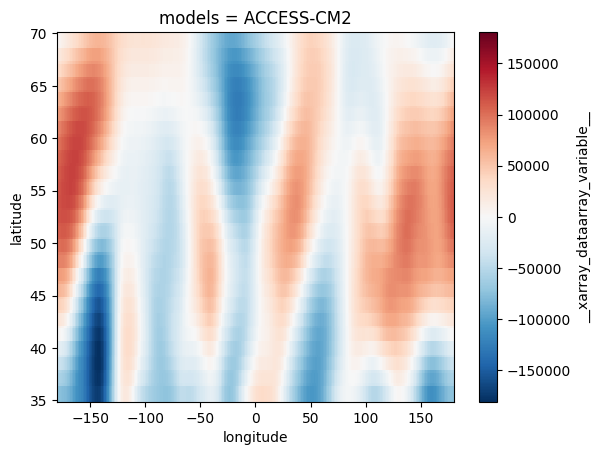

In [14]:
data[0].plot()

## Rank Histogram

how to calculate the rank histograms, this takes some time

In [15]:
n = 33
ranks = {i: 0 for i in range(1, n+2)} # create ranks for plotting,n is number of models, +1 for ranks

In [16]:
import bisect

for lat in data.latitude:
    for lon in data.longitude:
        model_values = []
        for m in range(33):
            model_value = float(data[m].sel(latitude=lat, longitude=lon))
            model_values.append(model_value)
        era5 = float(daJJA_1979_2014_trend.sel(latitude=lat, longitude=lon))
        # sort the list of ensemble values
        model_values_sorted = sorted(model_values)
        # find the rank of era5 
        rank = bisect.bisect_left(model_values_sorted, era5) + 1 #add 1
        #print(rank)
        #now add the count to the ranks dictionary
        ranks[rank] += 1
        

### outcome:

In [17]:
ranks = {1: 364,
 2: 707,
 3: 670,
 4: 697,
 5: 381,
 6: 607,
 7: 626,
 8: 414,
 9: 391,
 10: 629,
 11: 897,
 12: 1229,
 13: 1681,
 14: 1591,
 15: 1905,
 16: 1929,
 17: 2295,
 18: 3325,
 19: 2983,
 20: 3349,
 21: 4278,
 22: 5854,
 23: 7866,
 24: 12085,
 25: 10262,
 26: 11357,
 27: 14305,
 28: 16523,
 29: 18669,
 30: 15582,
 31: 17682,
 32: 13758,
 33: 16631,
 34: 11518}

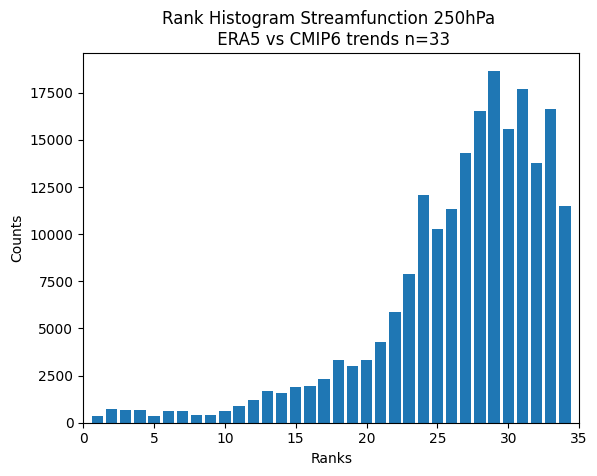

In [18]:
rank_keys = list(ranks.keys())
rank_values = list(ranks.values())

plt.bar(rank_keys, rank_values)

plt.xlabel("Ranks")
plt.ylabel("Counts")
plt.xlim(0,35)

plt.title(f"Rank Histogram Streamfunction 250hPa \n ERA5 vs CMIP6 trends n={n}")

plt.show()

## calculating and plotting rank histograms, with color = trend sign of ERA5

In [19]:
n = 33
ranks_2 = {i: 0 for i in range(1, n+2)} # create ranks for plotting,n is number of models, +1 for ranks
phase_count = {i: {"neg":0, "neutral": 0, "pos":0} for i in range(1, n+2)}

In [20]:
import bisect

for lat in data.latitude:
    for lon in data.longitude:
        model_values = []
        for m in range(33):
            model_value = float(data[m].sel(latitude=lat, longitude=lon))
            model_values.append(model_value)
        era5 = float(daJJA_1979_2014_trend.sel(latitude=lat, longitude=lon))
        
        # sort the list of ensemble values
        model_values_sorted = sorted(model_values)
        # find the rank of era5 
        rank = bisect.bisect_left(model_values_sorted, era5) + 1 #add 1
        #print(rank)
        #now add the count to the ranks dictionary
        ranks_2[rank] += 1
        
        #check phase of era5 trend
        if era5 <= -5000:
            phase_count[rank]["neg"] += 1
        elif era5 >= 5000:
            phase_count[rank]["pos"] += 1
        else:
            phase_count[rank]["neutral"] += 1

#### outcome:

In [21]:
phase_count = {1: {'neg': 364, 'neutral': 0, 'pos': 0},
 2: {'neg': 707, 'neutral': 0, 'pos': 0},
 3: {'neg': 670, 'neutral': 0, 'pos': 0},
 4: {'neg': 697, 'neutral': 0, 'pos': 0},
 5: {'neg': 381, 'neutral': 0, 'pos': 0},
 6: {'neg': 607, 'neutral': 0, 'pos': 0},
 7: {'neg': 607, 'neutral': 19, 'pos': 0},
 8: {'neg': 367, 'neutral': 47, 'pos': 0},
 9: {'neg': 250, 'neutral': 87, 'pos': 54},
 10: {'neg': 266, 'neutral': 80, 'pos': 283},
 11: {'neg': 194, 'neutral': 104, 'pos': 599},
 12: {'neg': 117, 'neutral': 160, 'pos': 952},
 13: {'neg': 15, 'neutral': 212, 'pos': 1454},
 14: {'neg': 81, 'neutral': 53, 'pos': 1457},
 15: {'neg': 153, 'neutral': 47, 'pos': 1705},
 16: {'neg': 132, 'neutral': 27, 'pos': 1770},
 17: {'neg': 140, 'neutral': 15, 'pos': 2140},
 18: {'neg': 52, 'neutral': 53, 'pos': 3220},
 19: {'neg': 62, 'neutral': 49, 'pos': 2872},
 20: {'neg': 55, 'neutral': 101, 'pos': 3193},
 21: {'neg': 17, 'neutral': 48, 'pos': 4213},
 22: {'neg': 7, 'neutral': 120, 'pos': 5727},
 23: {'neg': 0, 'neutral': 112, 'pos': 7754},
 24: {'neg': 0, 'neutral': 57, 'pos': 12028},
 25: {'neg': 0, 'neutral': 44, 'pos': 10218},
 26: {'neg': 0, 'neutral': 2, 'pos': 11355},
 27: {'neg': 0, 'neutral': 0, 'pos': 14305},
 28: {'neg': 0, 'neutral': 0, 'pos': 16523},
 29: {'neg': 0, 'neutral': 0, 'pos': 18669},
 30: {'neg': 0, 'neutral': 0, 'pos': 15582},
 31: {'neg': 0, 'neutral': 0, 'pos': 17682},
 32: {'neg': 0, 'neutral': 0, 'pos': 13758},
 33: {'neg': 0, 'neutral': 0, 'pos': 16631},
 34: {'neg': 0, 'neutral': 0, 'pos': 11518}}

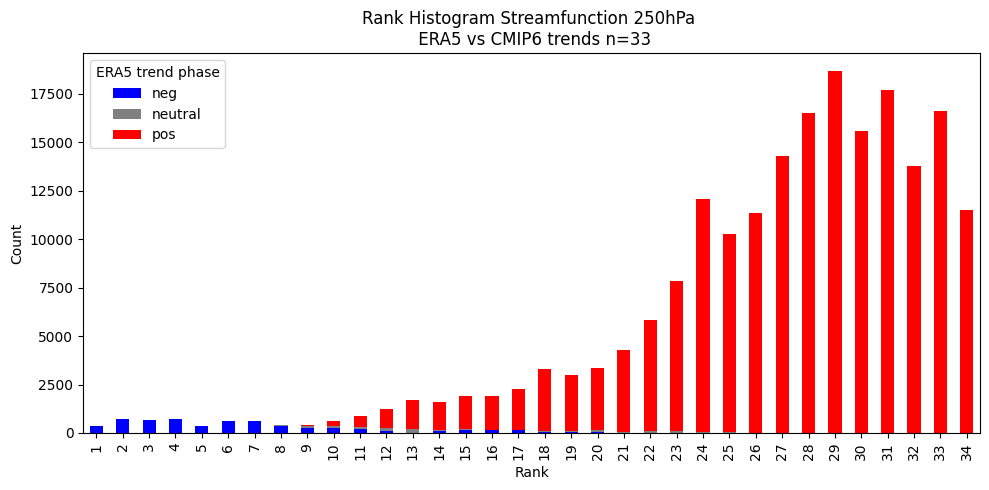

In [22]:
df = pd.DataFrame.from_dict(phase_count, orient='index')

# Plot stacked bar chart
df.plot(kind='bar', stacked=True, figsize=(10, 5), color=['blue', 'gray', 'red'])

# Add labels
plt.xlabel('Rank')
plt.ylabel('Count')
plt.title(f'Rank Histogram Streamfunction 250hPa \n ERA5 vs CMIP6 trends n={n}')
plt.legend(title='ERA5 trend phase')
plt.tight_layout()
plt.show()